### ChatBot building with Lang chain

- Langchain is a framework for building application base on LLM
- Business want to build their own LLM --> access to real data from their own database which CHATGPT cannot provide
- Concept to look at:
    - Vector Store
    - Embedding
- The whole idea is to turn text into a vector and stor into the vector base storage and train model to retrieve the data base how we train it to response to the answer.

```python  
conda install conda=23.7.4
pip install langchain
pip install pypdf
pip install gpt_index
pip install tiktoken
pip install os
```

https://colab.research.google.com/drive/1OZpmLgd5D_qmjTnL5AsD1_ZJDdb7LQZI?usp=sharing#scrollTo=-pHw5siewPNt


In [1]:
import os
import cchardet as chardet
from langchain.llms import OpenAI



In [2]:
# API call for chatgpt environment
OPENAI_API= os.environ["OPENAI_API_KEY"]


In [6]:
# import module to load pdf
from langchain.document_loaders import PyPDFLoader

# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages 
loader = PyPDFLoader("/Users/tinapham/Desktop/chatbot project/FAQ.pdf")
pages = loader.load_and_split()
print(pages[0])


page_content='•Are any Physicians accepting patients? When Physicians are able to accommodate new patients, this will be published on the website under Physicians page. •Can I get my results mailed to me or released over the phone? Depending on your Physician, some results may be released by mail or over the phone, or you may be asked to make another appointment with your Physician to review your result. Please clarify this with your Physician if you are expecting to be contacted about a speciﬁc test result. •Can I phone directly to make an appointment? You can phone our main line at 204-727-6451 and press option “3” to speak to a Receptionist to make your appointment. Please understand that phones are very busy and your time on hold will vary depending on call volumes at any given time. For a more convenient method please use our Online Booking option available on our website. It is very user-friendly and will provide you with conﬁrmation of your appointment. •What happens if I miss a

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
#import nltk
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [14]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("/Users/tinapham/Desktop/chatbot project/FAQ.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('FAQ.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('FAQ.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

In [15]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0]) 

langchain.schema.document.Document

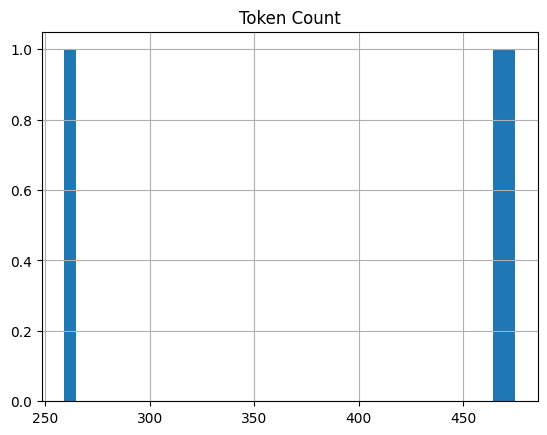

In [17]:
#Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [20]:
from langchain.vectorstores import FAISS

# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

In [21]:
# Check similarity search is working
query = "Are any Physicians accepting patients?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='• Are any Physicians accepting patients? \n\nWhen Physicians are able to accommodate new patients, this will be \npublished on the website under Physicians page. \n\n• Can I get my results mailed to me or released over the phone? \n\nDepending on your Physician, some results may be released by mail or over \nthe phone, or you may be asked to make another appointment with your \nPhysician to review your result. Please clarify this with your Physician if you \nare expecting to be contacted about a speciﬁc test result. \n\n• Can I phone directly to make an appointment? \n\nYou can phone our main line at 204-727-6451 and press option “3” to speak to \na Receptionist to make your appointment. Please understand that phones are \nvery busy and your time on hold will vary depending on call volumes at any \ngiven time. For a more convenient method please use our Online Booking \noption available on our website. It is very user-friendly and will provide you \nwith conﬁrmat

In [22]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Are any Physicians accepting patients?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' When Physicians are able to accommodate new patients, this will be published on the website under Physicians page.'